# Vacuum vs Implicit Solvent

Side-by-side comparison of alanine dipeptide in vacuum and implicit solvent
(GBSA/OBC). The implicit solvent reshapes the free energy landscape:
solvation stabilizes certain backbone conformations and shifts the relative
populations of the Ramachandran basins.

Same molecule, same force field, same simulation protocol. The only
difference is the GBSA solvation term.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as random

from openmm import unit
from openmmtools import testsystems

import jaxmm
from jaxmm import FEMTOSECOND, KB
from jaxmm.notebook import (
    show_structure, phi_psi_degrees, plot_ramachandran, free_energy_1d,
)

## Setup both systems

Build vacuum and implicit solvent ALDP, extract parameters, minimize.

In [2]:
# Vacuum
aldp_vac = testsystems.AlanineDipeptideVacuum(constraints=None)
params_vac = jaxmm.extract_params(aldp_vac.system)
pos0_vac = jnp.array(aldp_vac.positions.value_in_unit(unit.nanometer), dtype=jnp.float64)
pos_min_vac = jaxmm.minimize_energy(pos0_vac, params_vac)

# Implicit solvent (GBSA/OBC)
aldp_imp = testsystems.AlanineDipeptideImplicit(constraints=None)
params_imp = jaxmm.extract_params(aldp_imp.system)
pos0_imp = jnp.array(aldp_imp.positions.value_in_unit(unit.nanometer), dtype=jnp.float64)
pos_min_imp = jaxmm.minimize_energy(pos0_imp, params_imp)

print(f"Vacuum:   {params_vac.n_atoms} atoms, GBSA = {params_vac.gbsa is not None}")
print(f"Implicit: {params_imp.n_atoms} atoms, GBSA = {params_imp.gbsa is not None}")
print(f"\nVacuum min energy:   {float(jaxmm.total_energy(pos_min_vac, params_vac)):.2f} kJ/mol")
print(f"Implicit min energy: {float(jaxmm.total_energy(pos_min_imp, params_imp)):.2f} kJ/mol")

Vacuum:   22 atoms, GBSA = False
Implicit: 22 atoms, GBSA = True

Vacuum min energy:   -118.45 kJ/mol
Implicit min energy: -173.16 kJ/mol


## Run Langevin MD for both

Identical protocol: 1 fs timestep, 300K, 1/ps friction, 100 ps production
after 5 ps thermalization.

In [3]:
temperature = 300.0
n_prod = 100000  # 100 ps
save_every = 50

def run_md(pos_min, params, key):
    """Thermalize + production run."""
    # Thermalize
    res = jaxmm.langevin_baoab(
        pos_min, jnp.zeros_like(pos_min), params,
        dt=1.0 * FEMTOSECOND, temperature=temperature, friction=1.0,
        n_steps=5000, key=key,
    )
    # Production
    res = jax.jit(
        jaxmm.langevin_baoab, static_argnames=("n_steps", "save_every")
    )(
        res.positions, res.velocities, params,
        dt=1.0 * FEMTOSECOND, temperature=temperature, friction=1.0,
        n_steps=n_prod, save_every=save_every,
        key=random.fold_in(key, 1),
    )
    return res.trajectory_positions

traj_vac = run_md(pos_min_vac, params_vac, random.key(42))
traj_imp = run_md(pos_min_imp, params_imp, random.key(42))

# Discard first 20% as warmup
warmup = traj_vac.shape[0] // 5
traj_vac = traj_vac[warmup:]
traj_imp = traj_imp[warmup:]

print(f"Vacuum trajectory:   {traj_vac.shape}")
print(f"Implicit trajectory: {traj_imp.shape}")

Vacuum trajectory:   (1600, 22, 3)
Implicit trajectory: (1600, 22, 3)


## Ramachandran comparison

The key visual: which backbone conformations are populated in each
environment? Implicit solvent typically stabilizes the alpha-R basin
and shifts the C7eq/C7ax populations relative to vacuum.

In [ ]:
phi_vac, psi_vac = phi_psi_degrees(traj_vac, aldp_vac.topology)
phi_imp, psi_imp = phi_psi_degrees(traj_imp, aldp_imp.topology)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5))

plot_ramachandran(phi_vac, psi_vac, ax=ax1, title=f"Vacuum ({len(phi_vac)} frames)")
plot_ramachandran(phi_imp, psi_imp, ax=ax2, title=f"Implicit solvent ({len(phi_imp)} frames)")

plt.suptitle("Ramachandran: Vacuum vs Implicit Solvent (300K)", y=1.02)
plt.tight_layout()
plt.show()

## Free energy profiles along phi

1D marginal free energy F(phi) = -kBT ln P(phi) for both environments,
overlaid on the same axes.

In [ ]:
centers_vac, fe_vac = free_energy_1d(phi_vac, temperature, bins=72, sample_range=(-180, 180))
centers_imp, fe_imp = free_energy_1d(phi_imp, temperature, bins=72, sample_range=(-180, 180))

fig, ax = plt.subplots(figsize=(8, 4))
valid_v = ~np.isnan(fe_vac)
valid_i = ~np.isnan(fe_imp)
ax.plot(centers_vac[valid_v], fe_vac[valid_v], "o-", ms=3, lw=1.5, label="Vacuum")
ax.plot(centers_imp[valid_i], fe_imp[valid_i], "s-", ms=3, lw=1.5, label="Implicit")
ax.set_xlabel(r"$\phi$ (deg)")
ax.set_ylabel(r"$F(\phi)$ (kJ/mol)")
ax.set_xlim(-180, 180)
ax.set_title("Free energy along phi: vacuum vs implicit solvent")
ax.legend()
plt.tight_layout()
plt.show()

## Energy distributions

The implicit solvent adds a GBSA solvation contribution that shifts
the energy distribution to lower values.

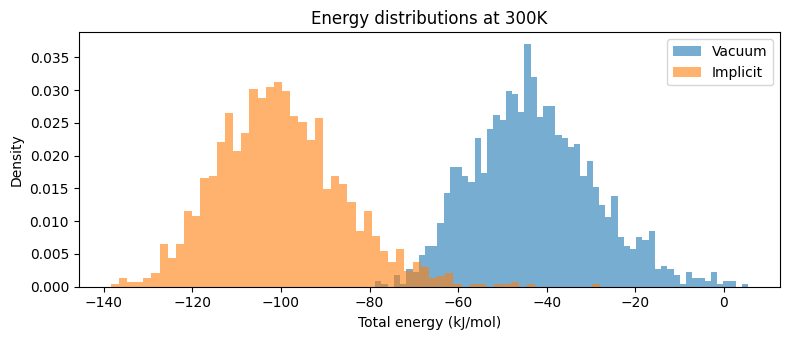

Vacuum:   mean = -42.8, std = 13.7 kJ/mol
Implicit: mean = -100.2, std = 14.0 kJ/mol


In [6]:
vmap_energy = jax.jit(jax.vmap(jaxmm.total_energy, in_axes=(0, None)))
energies_vac = np.array(vmap_energy(traj_vac, params_vac))
energies_imp = np.array(vmap_energy(traj_imp, params_imp))

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.hist(energies_vac, bins=60, alpha=0.6, density=True, label="Vacuum")
ax.hist(energies_imp, bins=60, alpha=0.6, density=True, label="Implicit")
ax.set_xlabel("Total energy (kJ/mol)")
ax.set_ylabel("Density")
ax.set_title("Energy distributions at 300K")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Vacuum:   mean = {energies_vac.mean():.1f}, std = {energies_vac.std():.1f} kJ/mol")
print(f"Implicit: mean = {energies_imp.mean():.1f}, std = {energies_imp.std():.1f} kJ/mol")

## Per-term decomposition

Compare mean energy contributions. The GBSA term (present only in implicit)
is a significant stabilizing contribution. Bonded terms should be similar
between the two since they share the same force field.

In [7]:
vmap_comp = jax.jit(jax.vmap(jaxmm.energy_components, in_axes=(0, None)))
comp_vac = vmap_comp(traj_vac, params_vac)
comp_imp = vmap_comp(traj_imp, params_imp)

# Gather all term names
all_terms = list(comp_imp.keys())  # implicit has more terms (gbsa)

print(f"{'Term':>12s} {'Vacuum':>12s} {'Implicit':>12s} {'Diff':>10s}")
print("-" * 50)
for term in all_terms:
    mean_v = float(np.array(comp_vac[term]).mean()) if term in comp_vac else float('nan')
    mean_i = float(np.array(comp_imp[term]).mean())
    diff = mean_i - mean_v if term in comp_vac else mean_i
    v_str = f"{mean_v:12.2f}" if term in comp_vac else f"{'N/A':>12s}"
    print(f"{term:>12s} {v_str} {mean_i:12.2f} {diff:10.2f}")

        Term       Vacuum     Implicit       Diff
--------------------------------------------------
      angles        36.86        36.39      -0.47
       bonds        27.92        27.57      -0.35
        gbsa          N/A       -62.18     -62.18
   nonbonded      -127.65      -120.74       6.92
    torsions        20.09        18.77      -1.32


## Structure comparison

Visualize the minimized structures from each environment.

In [ ]:
phi_idx = jnp.array(jaxmm.phi_indices(aldp_vac.topology))
psi_idx = jnp.array(jaxmm.psi_indices(aldp_vac.topology))

phi_vac_min = float(np.degrees(jaxmm.dihedral_angle(pos_min_vac, phi_idx)[0]))
psi_vac_min = float(np.degrees(jaxmm.dihedral_angle(pos_min_vac, psi_idx)[0]))
view = show_structure(
    pos_min_vac, aldp_vac.topology,
    label=f"Vacuum minimum: phi={phi_vac_min:.0f}, psi={psi_vac_min:.0f}",
)
view.show()

In [ ]:
phi_imp_min = float(np.degrees(jaxmm.dihedral_angle(pos_min_imp, phi_idx)[0]))
psi_imp_min = float(np.degrees(jaxmm.dihedral_angle(pos_min_imp, psi_idx)[0]))
view = show_structure(
    pos_min_imp, aldp_imp.topology,
    label=f"Implicit minimum: phi={phi_imp_min:.0f}, psi={psi_imp_min:.0f}",
)
view.show()